# Notebook ICD - 17

### Library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed for reproducibility
np.random.seed(42)

### Dataset

Remembering Iris dataset from `scikit-learn` contains 150 samples of iris flowers, classified into three species. Each sample has four features: sepal length, sepal width, petal length, and petal width.

In [2]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

### Individual classifiers

In [3]:
# Define base classifiers
classifiers = {
    'CART': DecisionTreeClassifier(),
    'GNB': GaussianNB(),
    'kNN': KNeighborsClassifier(),
    'SVM': SVC(kernel='linear', probability=True)
}

### Define Ensemble classifiers

Gradient Boosting builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced.

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator. Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses. In majority voting, the predicted class label for a particular sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier.

In [4]:
# Define ensemble classifiers
ensemble_classifiers = {
    'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10),
    'Boosting': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10),
    'Stacking': StackingClassifier(estimators=[('cart', DecisionTreeClassifier()), ('svm', SVC(probability=True))], final_estimator=RandomForestClassifier()),
    'Voting': VotingClassifier(estimators=[('cart', DecisionTreeClassifier()), ('gnb', GaussianNB()), ('knn', KNeighborsClassifier())], voting='soft')
}

### Evaluating Models with 10-Fold Cross-Validation

We will use 10-fold cross-validation to evaluate each classifier, storing the F1-scores for each fold iteration. We'll store these scores to calculate the average and standard deviation of F1-scores later.

In [5]:
# Define cross-validation and F1 scorer
kf = KFold(n_splits=10, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='macro')

# Function to evaluate a model with cross-validation
def evaluate_model(model, X, y, kf):
    f1_scores = cross_val_score(model, X, y, cv=kf, scoring=f1_scorer)
    return f1_scores

# Dictionary to store results
results = {}

# Evaluate individual classifiers
for name, clf in classifiers.items():
    f1_scores = evaluate_model(clf, X, y, kf)
    results[name] = f1_scores

# Evaluate ensemble classifiers
for name, clf in ensemble_classifiers.items():
    f1_scores = evaluate_model(clf, X, y, kf)
    results[name] = f1_scores

### Reporting Global Results

For each model, we will calculate and display the mean and standard deviation of the F1-scores across the 10 folds. This will give us a sense of the overall performance and consistency of each classifier.

In [6]:
# Print average F1-score and standard deviation for each classifier
for name, f1_scores in results.items():
    print(f"{name}: Mean F1-score = {np.mean(f1_scores):.3f}, Standard Deviation = {np.std(f1_scores):.3f}")

CART: Mean F1-score = 0.945, Standard Deviation = 0.061
GNB: Mean F1-score = 0.962, Standard Deviation = 0.052
kNN: Mean F1-score = 0.971, Standard Deviation = 0.051
SVM: Mean F1-score = 0.971, Standard Deviation = 0.051
Bagging: Mean F1-score = 0.946, Standard Deviation = 0.054
Boosting: Mean F1-score = 0.946, Standard Deviation = 0.061
Stacking: Mean F1-score = 0.965, Standard Deviation = 0.049
Voting: Mean F1-score = 0.960, Standard Deviation = 0.057


### Visualizing the Results with a Boxplot and Mean Markers

We will use a boxplot to visualize the distribution of F1-scores for each model across the 10 folds. Additionally, we will display the mean F1-score for each model using a point marker on the plot.

/var/folders/38/w8zx9pw96ml6x9h41ms703nm0000gn/T/ipykernel_56664/3256645782.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(i, mean_f1_scores[i], color='red', marker='o', s=10, zorder=3, label='Mean F1-score' if i == 0 else "")


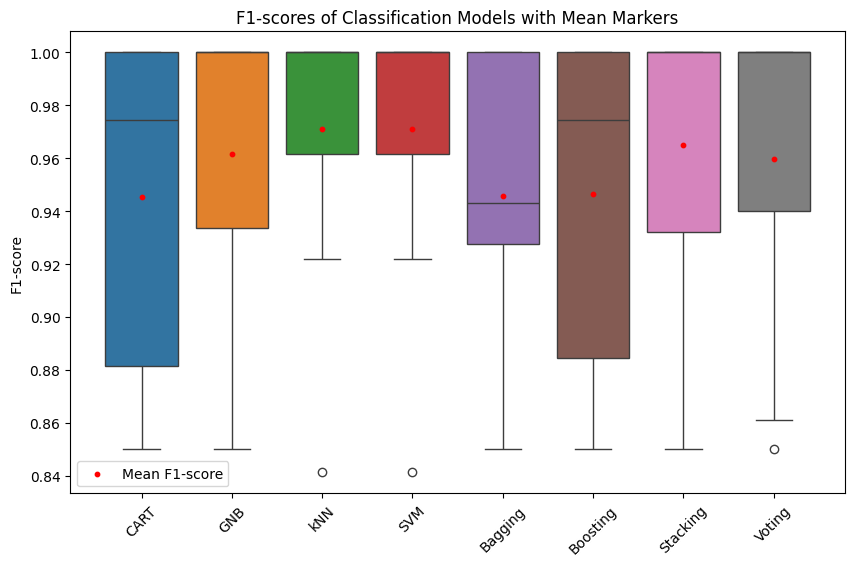

In [7]:
# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Create the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=results_df)  # Boxplot

# Compute mean F1-score for each model
mean_f1_scores = results_df.mean()

# Plot the mean F1-score for each model with a red marker
for i in range(len(mean_f1_scores)):
    # x-coordinate is the position of the category (i), y-coordinate is the mean F1-score
    plt.scatter(i, mean_f1_scores[i], color='red', marker='o', s=10, zorder=3, label='Mean F1-score' if i == 0 else "")

# Customize the plot
plt.title('F1-scores of Classification Models with Mean Markers')
plt.ylabel('F1-score')
plt.xticks(ticks=np.arange(len(results_df.columns)), labels=results_df.columns, rotation=45)

# Only show the legend once
plt.legend()

# Display the plot
plt.show()

### Displaying the Confusion Matrix for the Best Models

We will now display the confusion matrices for the best-performing model from the base classifiers and the best-performing model from the ensemble classifiers, based on their mean F1-scores.

Confusion Matrix for the best base model (kNN):


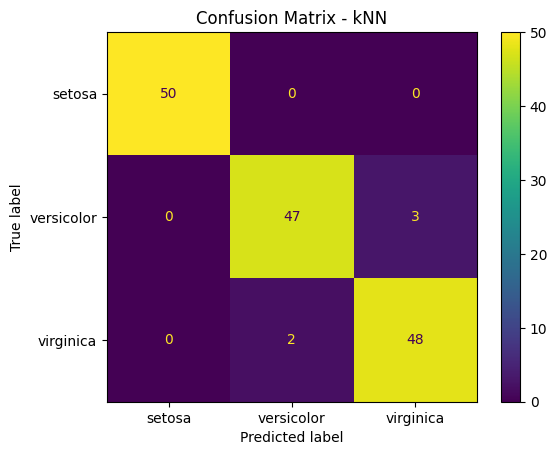

Confusion Matrix for the best ensemble model (Stacking):


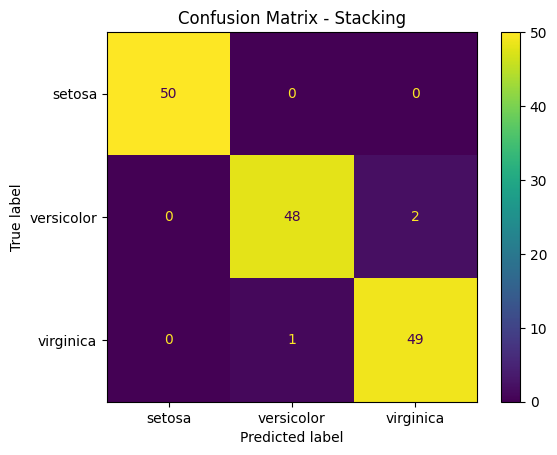

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the best base classifier and best ensemble classifier based on mean F1-scores
best_base_model_name = results_df[classifiers.keys()].mean().idxmax()
best_ensemble_model_name = results_df[ensemble_classifiers.keys()].mean().idxmax()

best_base_model = classifiers[best_base_model_name]
best_ensemble_model = ensemble_classifiers[best_ensemble_model_name]

# Train the best base model and best ensemble model on the entire dataset
best_base_model.fit(X, y)
best_ensemble_model.fit(X, y)

# Predict using the trained models
y_pred_base = best_base_model.predict(X)
y_pred_ensemble = best_ensemble_model.predict(X)

# Generate confusion matrices
conf_matrix_base = confusion_matrix(y, y_pred_base)
conf_matrix_ensemble = confusion_matrix(y, y_pred_ensemble)

# Display confusion matrix for the best base model
print(f"Confusion Matrix for the best base model ({best_base_model_name}):")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_base, display_labels=iris.target_names).plot()
plt.title(f"Confusion Matrix - {best_base_model_name}")
plt.show()

# Display confusion matrix for the best ensemble model
print(f"Confusion Matrix for the best ensemble model ({best_ensemble_model_name}):")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ensemble, display_labels=iris.target_names).plot()
plt.title(f"Confusion Matrix - {best_ensemble_model_name}")
plt.show()

## Unbalanced dataset

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Set random seed
np.random.seed(42)

# Load the Credit Card Fraud dataset (downloaded locally or from Kaggle)
data = pd.read_csv('creditcard.csv')

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Define base classifiers
classifiers = {
    'CART': DecisionTreeClassifier(),
    'GNB': GaussianNB(),
    'kNN': KNeighborsClassifier(),
    'SVM': SVC()
}

# Define ensemble classifiers
ensemble_classifiers = {
    'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42),
    'Boosting': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42),
    'Stacking': StackingClassifier(estimators=[('dt', DecisionTreeClassifier()), ('svc', SVC(probability=True))], final_estimator=RandomForestClassifier(), cv=5),
    'Voting': VotingClassifier(estimators=[('dt', DecisionTreeClassifier()), ('svc', SVC())], voting='hard')
}

# Combine classifiers into one dictionary for easier iteration
all_classifiers = {**classifiers, **ensemble_classifiers}

# Store the F1-scores for each model and fold
results = {name: [] for name in all_classifiers.keys()}

# 10-fold cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation for each classifier
for name, model in all_classifiers.items():
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Store F1-score
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name].append(f1)

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot a boxplot to visualize the distribution of F1-scores
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=results_df)

# Plot mean F1-score for each model with markers
mean_f1_scores = results_df.mean()
for i, mean in enumerate(mean_f1_scores):
    plt.scatter(i, mean, color='red', marker='o', s=10, zorder=3, label='Mean F1-score' if i == 0 else "")

# Customize the plot
plt.title('F1-scores of Classification Models (Credit Card Fraud Dataset)')
plt.ylabel('F1-score')
plt.xticks(ticks=np.arange(len(results_df.columns)), labels=results_df.columns, rotation=45)
plt.legend()
plt.show()

# Get the best base classifier and best ensemble classifier based on mean F1-scores
best_base_model_name = results_df[classifiers.keys()].mean().idxmax()
best_ensemble_model_name = results_df[ensemble_classifiers.keys()].mean().idxmax()

best_base_model = classifiers[best_base_model_name]
best_ensemble_model = ensemble_classifiers[best_ensemble_model_name]

# Train the best base model and best ensemble model on the entire dataset
best_base_model.fit(X, y)
best_ensemble_model.fit(X, y)

# Predict using the trained models
y_pred_base = best_base_model.predict(X)
y_pred_ensemble = best_ensemble_model.predict(X)

# Generate confusion matrices
conf_matrix_base = confusion_matrix(y, y_pred_base)
conf_matrix_ensemble = confusion_matrix(y, y_pred_ensemble)

# Display confusion matrix for the best base model
print(f"Confusion Matrix for the best base model ({best_base_model_name}):")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_base, display_labels=['No Fraud', 'Fraud']).plot()
plt.title(f"Confusion Matrix - {best_base_model_name}")
plt.show()

# Display confusion matrix for the best ensemble model
print(f"Confusion Matrix for the best ensemble model ({best_ensemble_model_name}):")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ensemble, display_labels=['No Fraud', 'Fraud']).plot()
plt.title(f"Confusion Matrix - {best_ensemble_model_name}")
plt.show()